In [180]:
import numpy as np
import pandas as pd
import sklearn
import tensorflow as tf
import matplotlib.pyplot as plt
import tensorflow_datasets as tfds
from helper_functions import create_tensorboard_callback, plot_loss_curves # get helper functions
from tensorflow.keras import mixed_precision, layers
from tensorflow.keras.layers.experimental import preprocessing

In [181]:
datasets = tfds.list_builders()
print("food101" in datasets) #remove

True


In [182]:
(train_data, test_data), ds_info = tfds.load(name = "food101", 
                                             split = ["train", "validation"], 
                                             shuffle_files = True,
                                             as_supervised = True, with_info = True)

In [183]:
# exploring data
ds_info.features

FeaturesDict({
    'image': Image(shape=(None, None, 3), dtype=uint8),
    'label': ClassLabel(shape=(), dtype=int64, num_classes=101),
})

In [184]:
class_names = ds_info.features["label"].names #check name of classes
class_names[:5]

['apple_pie', 'baby_back_ribs', 'baklava', 'beef_carpaccio', 'beef_tartare']

In [185]:
# checking what the train_daa looks like
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [186]:
train_data_one_sample = train_data.take(1)
train_data_one_sample

<_TakeDataset element_spec=(TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), TensorSpec(shape=(), dtype=tf.int64, name=None))>

In [187]:
for image, label in train_data_one_sample: #checking out more details
    print(f"""image datatype: {image.dtype}, \n
    image shape: {image.shape}, \n
    target class: {label},
    class name: {class_names[label]}
    """)

image datatype: <dtype: 'uint8'>, 

    image shape: (512, 512, 3), 

    target class: 77,
    class name: pork_chop
    


Text(0.5, 1.0, 'pork_chop')

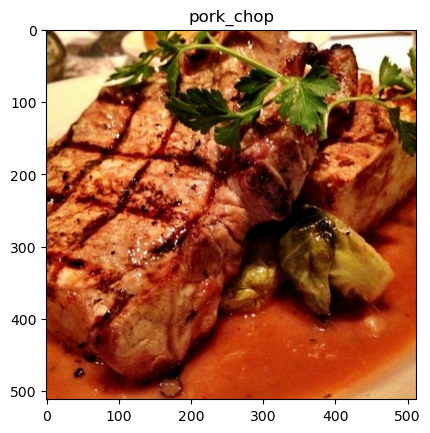

In [188]:
plt.imshow(image) #checking out image
plt.title(class_names[label])

In [189]:
# preprocessing
def preprocess_image(image, label, image_shape = 224):

    image = tf.image.resize(image, [image_shape, image_shape])
    return tf.cast(image, tf.float32), label # a tuple

In [190]:
preprocessed_image = preprocess_image(image, label)[0] #0 index cuz I want image from tuple
print(f"image before preprocessing: \n {image[:2]}..., \n shape: {image.shape}, \ndatatype: {image.dtype}")
print(f"image after preprocessing: \n {preprocessed_image[:2]}..., \n shape: {preprocessed_image.shape}, \ndatatype: {preprocessed_image.dtype}")

image before preprocessing: 
 [[[ 64  27  11]
  [ 73  36  20]
  [ 83  46  28]
  ...
  [150 105  82]
  [138  93  72]
  [134  89  68]]

 [[ 69  32  16]
  [ 70  33  17]
  [ 72  35  17]
  ...
  [155 110  87]
  [141  96  75]
  [135  90  69]]]..., 
 shape: (512, 512, 3), 
datatype: <dtype: 'uint8'>
image after preprocessing: 
 [[[ 69.69388    32.69388    16.693878 ]
  [ 78.44898    41.44898    22.520409 ]
  [ 78.35204    42.566326   16.137754 ]
  ...
  [211.34154   166.91301   141.69875  ]
  [172.38239   127.382385  104.382385 ]
  [138.04063    93.040634   72.040634 ]]

 [[ 63.693874   28.290815   10.499998 ]
  [ 60.137756   25.137754    3.2857132]
  [ 68.54082    33.484695    5.198978 ]
  ...
  [208.20901   164.19371   136.76518  ]
  [184.3518    140.48448   113.76002  ]
  [146.6731    104.673096   79.74452  ]]]..., 
 shape: (224, 224, 3), 
datatype: <dtype: 'float32'>


Text(0.5, 1.0, 'after')

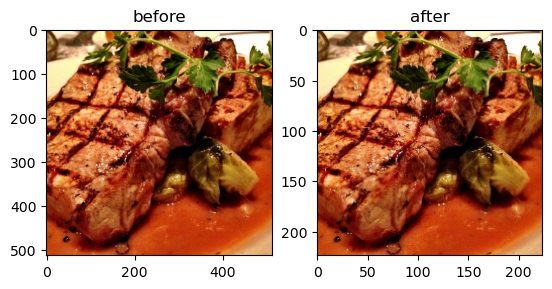

In [191]:
# plt.figure(figsize=(10, 4))
plt.subplot(1,2,1)
plt.imshow(image)
plt.title("before")
plt.subplot(1,2,2)
plt.imshow(preprocessed_image/255.)
plt.title("after")

In [192]:
#processing the entire training dataset
train_data = train_data.map(preprocess_image, tf.data.AUTOTUNE) 
# shuffle it using gpu (prefetch)
train_data = train_data.shuffle(buffer_size=len(train_data)).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

# now the test dataset - no need to shuffle test set
test_data = test_data.map(preprocess_image, tf.data.AUTOTUNE).batch(batch_size=32).prefetch(buffer_size=tf.data.AUTOTUNE)

In [193]:
train_data, test_data

(<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>,
 <_PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>)

In [194]:
# modelling callbacks
checkpoint_path = "model_checkpoints/checkpoint.ckpt"
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                     monitor="val_acc",
                                                     save_best_only=True,
                                                     save_weights_only=True,
                                                     verbose=0)

In [195]:
# mixed precision training
mixed_precision.set_global_policy("mixed_float16") # use float 16 where it can

In [196]:
# input_shape = (224,224,3)
# base_model = tf.keras.applications.EfficientNetB0(include_top=False)
# base_model.trainable=False

# inputs = layers.Input(shape=input_shape, name = "input_layer")
# x = base_model(inputs, training = False)
# x = layers.GlobalAveragePooling2D()(x)
# x = layers.Dense(len(class_names))(x)
# outputs = layers.Activation("softmax", dtype = tf.float32, name="softmax_float32")(x)
# model = tf.keras.Model(inputs, outputs)

model = tf.keras.models.load_model('saved_models/model_not_finetuned')

In [197]:
# # compiling
# model.compile(loss = "sparse_categorical_crossentropy",
#              optimizer =  tf.keras.optimizers.legacy.Adam(), #tf.keras.optimizers.Adam(),
#              metrics = ["accuracy"])

In [198]:
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_layer (InputLayer)    [(None, 224, 224, 3)]     0         
                                                                 
 efficientnetb0 (Functional  (None, None, None, 1280   4049571   
 )                           )                                   
                                                                 
 global_average_pooling2d (  (None, 1280)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 101)               129381    
                                                                 
 softmax_float32 (Activatio  (None, 101)               0         
 n)                                                              
                                                             

In [199]:
# for layer in model.layers:
#     print(f"layer name: {layer.name}, trainable: {layer.trainable}, datatype: {layer.dtype}, dtype policy: {layer.dtype_policy}")

In [200]:
# for layer in model.layers[1].layers:
#     print(f"layer name: {layer.name}, trainable: {layer.trainable}, datatype: {layer.dtype}, dtype policy: {layer.dtype_policy}")

In [201]:
# history = model.fit(x = train_data,
#                     epochs =3,
#                     steps_per_epoch=len(train_data),
#                     validation_data=test_data,
#                     validation_steps=0.15*len(test_data),
#                     callbacks = [create_tensorboard_callback("training_logs", "efficientnetb0"),
#                                 model_checkpoint
#                                 ])

In [203]:
feature_extract_model_result = model.evaluate(test_data)
feature_extract_model_result

790/790 [==============================] - 141s 179ms/step - loss: 0.9928 - accuracy: 0.7305


[0.9928053617477417, 0.7304554581642151]

In [204]:
# !mkdir -p saved_models
# model.save('saved_models/model_not_finetuned')

INFO:tensorflow:Assets written to: saved_models/model_not_finetuned/assets


INFO:tensorflow:Assets written to: saved_models/model_not_finetuned/assets


In [205]:
loaded_model_not_finetuned = tf.keras.models.load_model('saved_models/model_not_finetuned')

# model_not_finetuned = model.load('saved_models/model_not_finetuned')

In [206]:
for layer in model.layers[1].layers:
    print(f"layer name: {layer.name}, trainable: {layer.trainable}, datatype: {layer.dtype}, dtype policy: {layer.dtype_policy}")

layer name: input_1, trainable: True, datatype: float32, dtype policy: <Policy "float32">
layer name: rescaling, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: normalization, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: rescaling_1, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: stem_conv_pad, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: stem_conv, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: stem_bn, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: stem_activation, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: block1a_dwconv, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">
layer name: block1a_bn, trainable: False, datatype: float32, dtype policy: <Policy "mixed_float16">

In [208]:
loaded_model_not_finetuned_result = loaded_model_not_finetuned.evaluate(test_data)
loaded_model_not_finetuned_result

790/790 [==============================] - 143s 181ms/step - loss: 0.9928 - accuracy: 0.7305


[0.9928042888641357, 0.7304554581642151]

In [209]:
np.isclose(feature_extract_model_result, loaded_model_not_finetuned_result).all()

True

In [210]:
fine_tuned_model = tf.keras.models.load_model('saved_models/model_finetuned')

In [228]:
# for layer in fine_tuned_model.layers:
#     layer.trainable = True # set all layers to trainable
#     print(f"layer name: {layer.name}, trainable: {layer.trainable}, datatype: {layer.dtype}, dtype policy: {layer.dtype_policy}")

In [229]:
# for layer in fine_tuned_model.layers[1].layers[:20]:
#     print(layer.name, layer.trainable, layer.dtype, layer.dtype_policy)

In [230]:
# early_stopping = tf.keras.callbacks.EarlyStopping(monitor = "val_loss",
#                                                  patience = 3)

In [231]:
# checkpoint_path = "model_checkpoints/fine_tune_checkpoint.ckpt"
# model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
#                                                      monitor="val_loss",
#                                                      save_best_only=True)

In [232]:
# reduce_learning_rate = tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss",  
#                                                  factor=0.2, # reduce 5 times
#                                                  patience=2,
#                                                  verbose=1,
#                                                  min_lr=1e-7)

In [233]:
# fine_tuned_model.compile(loss="sparse_categorical_crossentropy", # sparse_categorical_crossentropy for labels that are *not* one-hot
#                         optimizer=tf.keras.optimizers.legacy.Adam(0.0001), # 10x lower learning rate than the default
#                         metrics=["accuracy"])

In [234]:
# fine_tuned_model_history = fine_tuned_model.fit(train_data,
#                                                epochs=100, # fine-tune for a maximum of 100 epochs
#                                                steps_per_epoch=len(train_data),
#                                                validation_data=test_data,
#                                                validation_steps=int(0.15 * len(test_data)),
#                                                callbacks=[create_tensorboard_callback("training_logs", "efficientnetb0"),
#                                                                                       model_checkpoint, # save only the best model during training
#                                                                                       early_stopping, # stop model after X epochs of no improvements
#                                                                                       reduce_learning_rate]) # reduce the learning rate after X epochs of no improvements

In [211]:
finetuned_feature_extract_model_result = fine_tuned_model.evaluate(test_data)
finetuned_feature_extract_model_result

790/790 [==============================] - 153s 178ms/step - loss: 1.0210 - accuracy: 0.8049


[1.0210386514663696, 0.8048712611198425]

In [38]:
# fine_tuned_model.save('saved_models/model_finetuned')

INFO:tensorflow:Assets written to: saved_models/model_finetuned/assets


INFO:tensorflow:Assets written to: saved_models/model_finetuned/assets


# now checking out the results

In [212]:
def plot_loss_curves(history):
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  accuracy = history.history['accuracy']
  val_accuracy = history.history['val_accuracy']

  epochs = range(len(history.history['loss']))

  # loss plot
  plt.plot(epochs, loss, label='training_loss')
  plt.plot(epochs, val_loss, label='val_loss')
  plt.title('Loss')
  plt.xlabel('Epochs')
  plt.legend()

  # accuracy plot
  plt.figure()
  plt.plot(epochs, accuracy, label='training_accuracy')
  plt.plot(epochs, val_accuracy, label='val_accuracy')
  plt.title('Accuracy')
  plt.xlabel('Epochs')
  plt.legend();

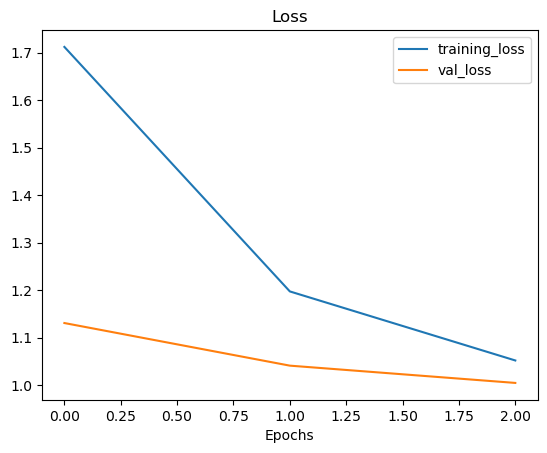

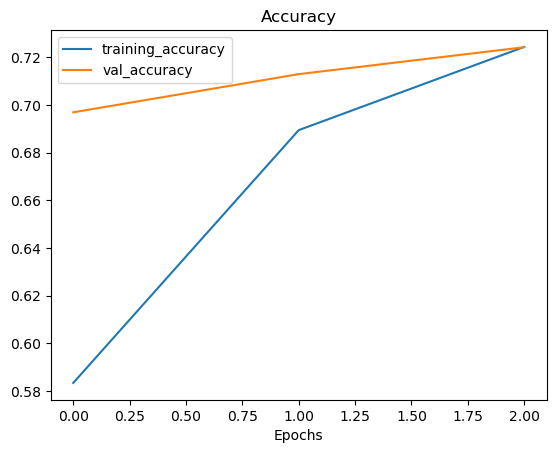

In [213]:
plot_loss_curves(history)

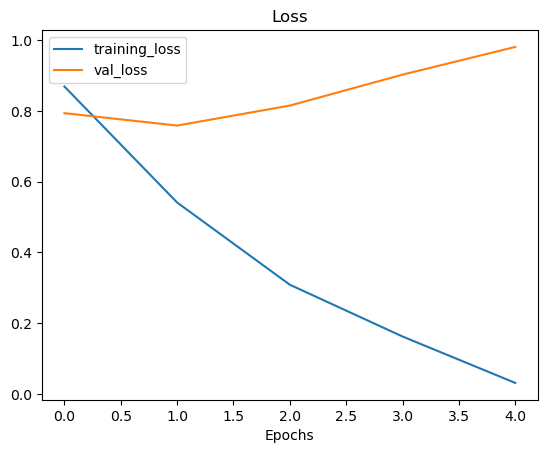

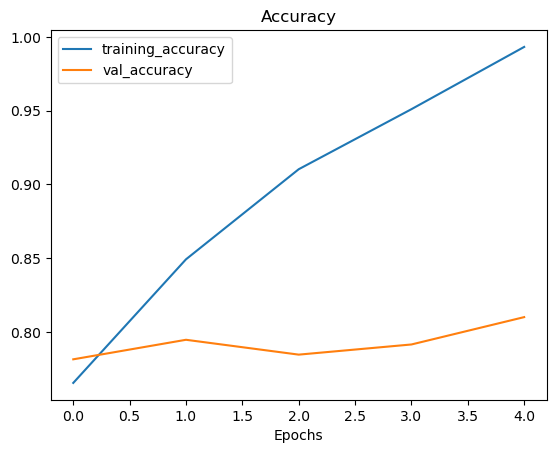

In [214]:
plot_loss_curves(fine_tuned_model_history)

## the above figures show that the fine tuned model is overfitting to the training data. Could freeze some layers and only train the last few layers, augment the data, reduce training time or implement regularisation techniques like as dropout or L1/L2. Using a smaller architecture or reducing the model complexity could also help prevent the model from learning the noise in the training data too well...